In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import shap
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import r2_score as R2, mean_absolute_error as MAE, mean_squared_error as MSE, accuracy_score as acs

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
pwd = os.getcwd()

In [3]:
df = pd.read_csv(pwd+"/Encoded_dataset/df_encoded_Voc.csv",low_memory=False)
df.shape

(26457, 30)

In [4]:
df.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure,JV_default_Voc
0,0.984353,0,0,0.976900,0.946769,370.0,0.985721,0,0,1,...,0.946647,0.940956,0,0.993400,148.0,0.966546,0.985235,80.0,0.968357,0.920
1,0.933317,0,0,0.954397,0.964355,279.6,0.959158,0,0,1,...,0.981932,1.005764,0,0.997601,34.0,0.966546,0.954824,100.0,0.968357,1.080
2,0.984353,0,0,0.976900,0.956950,480.0,0.980591,0,0,1,...,0.922134,0.913764,0,0.870000,218.0,0.969644,0.985235,50.0,0.968357,0.689
3,0.984353,0,0,0.954397,0.997100,279.6,0.976025,0,0,1,...,0.974922,0.967115,0,0.993400,34.0,0.966546,0.954824,100.0,0.968357,1.080
4,0.984353,0,0,0.976900,0.956950,230.0,0.980591,1,0,0,...,0.892650,0.965245,0,0.993400,20.0,0.966546,0.985235,80.0,0.968357,0.813


In [5]:
# Select feature list and target variable
X = df.iloc[:,:-1]
y = df['JV_default_Voc']  
print(f"Shape of X: {str(X.shape)}\nShape of y: {str(y.shape)}")

Shape of X: (26457, 29)
Shape of y: (26457,)


#### Loading new sample cell dataframe for prediction

In [6]:
new_X = pd.read_csv(pwd+"/Cell_to_predict/cell_encoded_Voc.csv")
new_X

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,0.984353,0,0,0.9769,0.9971,40.0,0.976025,0,0,1,...,0,0.967574,0.967574,0,0.87,20.0,0.966546,0.954824,100.0,0.968357


## Scaling Features

In [7]:
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
new_X[new_X.columns] = scaler.transform(new_X[new_X.columns])

In [8]:
X.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,1.000000,0.0,0.0,0.850091,0.624099,0.014780,0.711099,0.0,0.0,1.0,...,0.0,0.374114,0.379818,0.0,0.713547,0.00588,0.648297,0.755073,0.000650,0.558249
1,0.661472,0.0,0.0,0.714394,0.673521,0.011164,0.608886,0.0,0.0,1.0,...,1.0,0.426500,0.496248,0.0,0.725947,0.00132,0.648297,0.674818,0.000817,0.558249
2,1.000000,0.0,0.0,0.850091,0.652710,0.019180,0.691359,0.0,0.0,1.0,...,0.0,0.337719,0.330966,0.0,0.349233,0.00868,0.658147,0.755073,0.000400,0.558249
3,1.000000,0.0,0.0,0.714394,0.765541,0.011164,0.673789,0.0,0.0,1.0,...,1.0,0.416093,0.426812,0.0,0.713547,0.00132,0.648297,0.674818,0.000817,0.558249
4,1.000000,0.0,0.0,0.850091,0.652710,0.009180,0.691359,1.0,0.0,0.0,...,0.0,0.293945,0.423453,0.0,0.713547,0.00076,0.648297,0.755073,0.000650,0.558249


In [9]:
new_X.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,1.0,0.0,0.0,0.850091,0.765541,0.00158,0.673789,0.0,0.0,1.0,...,0.0,0.405184,0.427638,0.0,0.349233,0.00076,0.648297,0.674818,0.000817,0.558249


In [10]:
X_train, X_test, y_train, y_test = TTS(X,y,test_size=0.3,random_state=42)
print(f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

X_train: (18519, 29) 
X_test: (7938, 29) 
y_train: (18519,) 
y_test: (7938,)


In [11]:
def parity_plot(predicted_train, predicted_test, y1=y_train, y2=y_test):
    """ Plots the Predicted Voc vs Actual Voc"""
    plt.style.use('default')
    plt.figure(figsize=(5,5))
    plt.scatter(y1, predicted_train, c='r', label='Training data', edgecolors=(0, 0, 0), marker="o",s=100)
    plt.scatter(y2, predicted_test, c='b', label='Test data', edgecolors=(0, 0, 0), marker="o",s=100)
    plt.plot([-0.1, 2.0], [-0.1, 2.0], 'k--', lw=2)
    plt.xlim(-0.1, 2.0)
    plt.ylim(-0.1, 2.0)
    plt.xlabel('Actual Voc (V)')
    plt.ylabel('Predicted Voc (V)')
    plt.legend(loc="upper left")
    
    plt.savefig(pwd+'/Parity_plots_RF/parity_plot_Voc.png', dpi=600)
    return plt.show()

def get_evaluation(train_pred_y,test_pred_y):
    """ Gets ML model metrics Mean Square Error, Root Mean Square Error, Mean Absolute Error and R2 Score """
    # Metrics for Training Dataset
    mse_train = MSE(y_train, train_pred_y)
    rmse_train = np.sqrt(mse_train)
    mae_train = MAE(y_train, train_pred_y)
    r2_train = R2(y_train,train_pred_y)
   
    # Metrics for Test Dataset
    mse_test = MSE(y_test, test_pred_y)
    rmse_test = np.sqrt(mse_test)
    mae_test = MAE(y_test, test_pred_y)
    r2_test = R2(y_test,test_pred_y)

    eval_df = pd.DataFrame({
        "Metrics":["Mean Square Error (MSE)","Root Mean Square Error (RMSE)","Mean Absolute Error (MAE)","R2_Score"],
        "Training Data": [mse_train,rmse_train,mae_train,r2_train],
        "Test Data": [mse_test,rmse_test,mae_test,r2_test]
    })
    return eval_df

def model_builder(model_name):
    model_name.fit(X_train, y_train)
    y_pred_train = model_name.predict(X_train)
    y_pred_test = model_name.predict(X_test)
    parity_plot(y_pred_train,y_pred_test)
    eval_df = get_evaluation(y_pred_train,y_pred_test)
    return eval_df

### Random Forest Regressor

In [12]:
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto','sqrt', 'log2', None] # Warning - 'max_features' 'auto' is deprecated. 
}

# Define the search object
search = RandomizedSearchCV(rf, param_grid, cv=5, n_iter=50, n_jobs=-1, random_state=42)

# Fit the search object to the training data
search.fit(X_train, y_train)

# Print the best parameters
print(f'Best parameters: {search.best_params_}')

# Get the best model
best_rf = search.best_estimator_

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


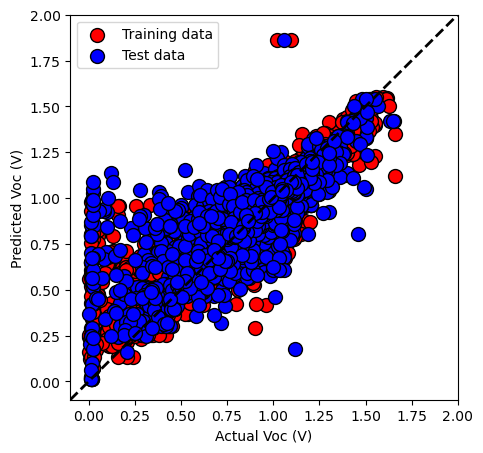

,Metrics,Training Data,Test Data
0,Mean Square Error (MSE),0.005199,0.010366
1,Root Mean Square Error (RMSE),0.072103,0.101813
2,Mean Absolute Error (MAE),0.038276,0.056445
3,R2_Score,0.841530,0.682693


In [13]:
best_rf_metrics = model_builder(best_rf)
best_rf_metrics

In [14]:
pickle.dump(best_rf, open(pwd + '/Hp_tuned_best_models/best_rf_Voc.sav', 'wb'))

In [15]:
predicted_Voc_rf = best_rf.predict(new_X)
predicted_Voc_rf

array([0.66066333])

### Feature Importances

In [16]:
features = X.columns.to_list()
importances = best_rf.feature_importances_

In [17]:
imp_df = pd.DataFrame({"Features": features, "Importance": importances})
imp_df_sorted = imp_df.sort_values(by=["Importance"])
imp_df_sorted

,Features,Importance
16,Perovskite_band_gap_graded,0.000082
10,Perovskite_dimension_3D_with_2D_capping_layer,0.000178
8,Perovskite_dimension_2D3D_mixture,0.001098
22,Perovskite_deposition_solvent_annealing,0.001457
1,Cell_flexible,0.001898
7,Perovskite_dimension_2D,0.002854
2,Cell_semitransparent,0.002860
11,Perovskite_composition_perovskite_ABC3_structure,0.003572
9,Perovskite_dimension_3D,0.004067
14,Perovskite_composition_inorganic,0.006990


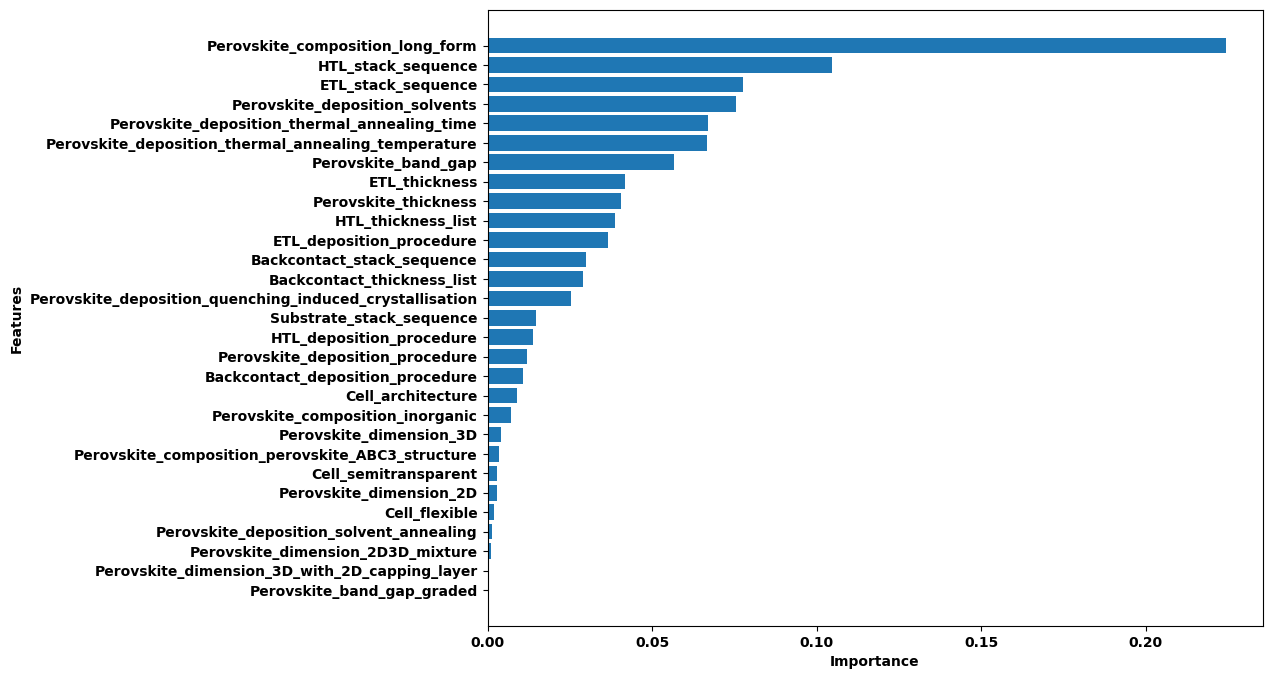

In [18]:
fig = plt.figure(figsize=(10,8))
plt.rcParams['font.weight']='bold'
plt.barh(imp_df_sorted["Features"],imp_df_sorted["Importance"])
plt.xlabel("Importance",weight='bold')
plt.ylabel("Features",weight='bold')
plt.savefig(pwd+"/Feature_Importances_Plots/RF_FI_Voc.png", bbox_inches='tight', dpi=600)
plt.show()

### Shap Analysis

In [19]:
explainer = shap.TreeExplainer(best_rf, X_test)
shap_values = explainer.shap_values(X_test, check_additivity=False)

100%|===================| 7928/7938 [14:03<00:01]        

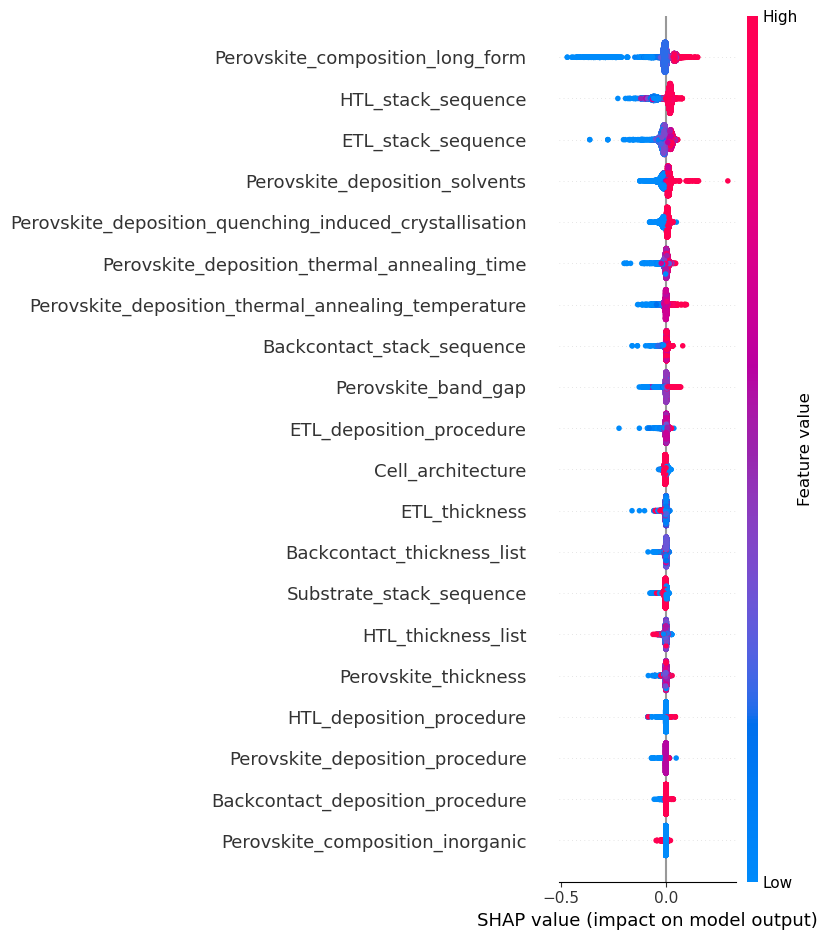

In [20]:
shap_fig = plt.figure()
shap.summary_plot(shap_values, X_test)
shap_fig.savefig(pwd+"/Feature_Importances_Plots/rf_shap_voc.png", bbox_inches='tight', dpi=500)